In [1]:
import sys
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from tqdm import tqdm_notebook
from catboost import Pool, CatBoostClassifier
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
from optuna.trial import Trial
from optuna.samplers import TPESampler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "/home/kenny/sber_ds_case/data/raw/test.csv"

In [3]:
data = pd.read_csv(data_path)

In [4]:
data

,title,text,topic
0,Британцы отмечают двухлетие смерти Дианы,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
1,Еще одно землетрясение в Турции: один человек ...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
2,Российские национал-большевики убирают террито...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
3,Киргизия ведет бои на границах с Таджикистаном...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
4,Литва засудила участников переворота 91 года,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
...,...,...,...
432153,Россия предложила Китаю участвовать в судьбе р...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
432154,Моуринью сравнил футболистов с мебелью,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Спорт
432155,Путин предостерег от запретов рэп-концертов,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Культура
432156,«Желтые жилеты» прорвали кордон полиции под «М...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир


In [5]:
data.topic.unique()

array(['Мир', 'Экономика', 'Интернет и СМИ', 'Спорт', 'Культура',
       'Наука и техника'], dtype=object)

проверим наличие пустых данных

In [6]:
data.isna().sum()

title    0
text     0
topic    0
dtype: int64

<Axes: xlabel='topic'>

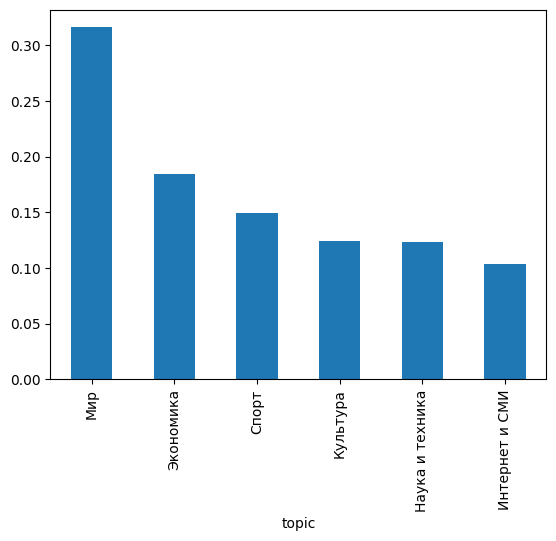

In [7]:
# проверим баланс классов целевой переменной
data['topic'].value_counts(normalize = True).plot.bar()

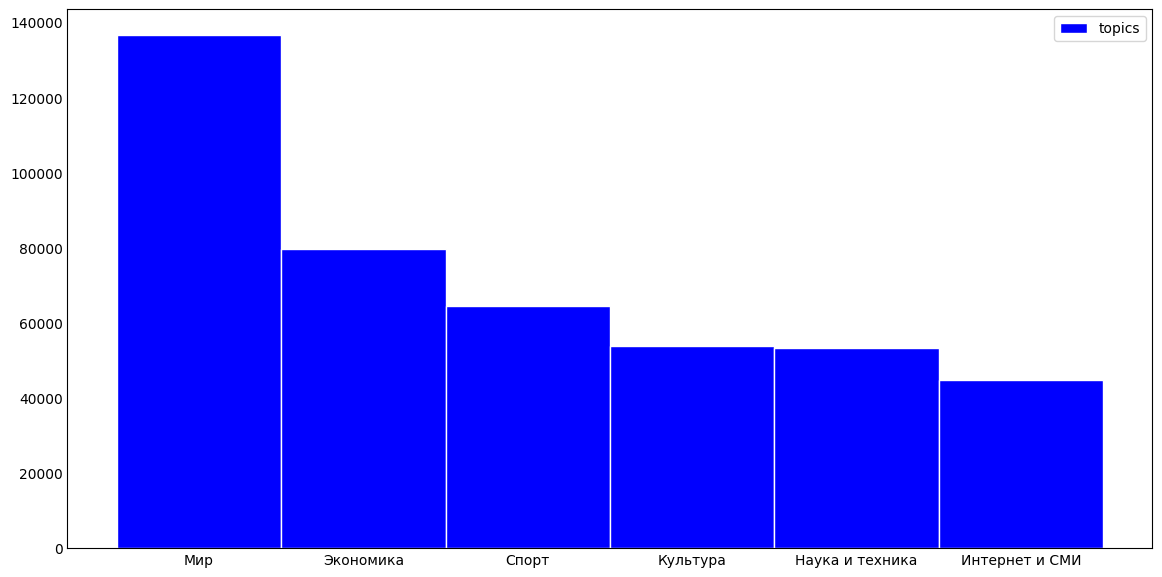

In [8]:
values = list(data.topic.value_counts())
topics = list(data.topic.value_counts().index)

plt.figure(figsize = (14,7))
plt.style.use('_mpl-gallery')
plt.grid()
plt.bar(topics, values, width=1, edgecolor="white", linewidth=1, label='topics', color='b')
plt.legend(loc = 1)

# Обработка данных

In [3]:
!sh data/preprocessing.sh data/preprocessing.py 50000 

100%|████████████████████████████████████| 50000/50000 [02:48<00:00, 296.75it/s]


# Посмотрим на обработанные данные

In [3]:
processed_data_path = "/home/kenny/sber_ds_case/data/processed/train_data.csv"

In [6]:
processed_data = pd.read_csv(processed_data_path)

In [7]:
processed_data

,title,text,topic,full_text
0,Неймар купил пятиэтажку в пригороде Парижа,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Спорт,неймара купить пятиэтажка пригород париж напад...
1,Официальный евро упал ниже 69 рублей,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Экономика,официальный евро упасть ниже 69 рубль официаль...
2,Гребец опубликовал фото ладоней после плавания...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Спорт,гребец опубликовать фото ладонь плавание север...
3,Плющенко рассказал о вреде «Ледникового период...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Спорт,плющенко рассказать вред ледниковый период сот...
4,Генконсульство России в Сан-Франциско назвало ...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир,генконсульство россия сан франциско назвать чи...
...,...,...,...,...
432153,Минобрнауки измерит патриотизм в World of Tank...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Наука и техника,минобрнауки измерить патриотизм world of tanks...
432154,Букмекеры предрекли победу шейха Салмана на вы...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Спорт,букмекер предречь победа шейх салман выборы пр...
432155,В Москве на «Робоелке» начнет работу детский т...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Наука и техника,москва робоёлка начать работа детский технопар...
432156,Жириновский заявил о передаче Путину запрещенн...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Интернет и СМИ,жириновский заявить передача путин запретить в...


In [8]:
processed_data.topic = processed_data.topic.map({'Мир':0, 'Экономика':1, 'Интернет и СМИ':2, 'Спорт':3, 'Культура':4,'Наука и техника':5})
processed_data.topic.unique()

array([3, 1, 0, 2, 4, 5])

In [9]:
processed_data.head(7)

,title,text,topic,full_text
0,Неймар купил пятиэтажку в пригороде Парижа,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",3,неймара купить пятиэтажка пригород париж напад...
1,Официальный евро упал ниже 69 рублей,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",1,официальный евро упасть ниже 69 рубль официаль...
2,Гребец опубликовал фото ладоней после плавания...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",3,гребец опубликовать фото ладонь плавание север...
3,Плющенко рассказал о вреде «Ледникового период...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",3,плющенко рассказать вред ледниковый период сот...
4,Генконсульство России в Сан-Франциско назвало ...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",0,генконсульство россия сан франциско назвать чи...
5,Популярный блогер стал мэром американского гор...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",2,популярный блогер стать мэр американский город...
6,СМИ узнали о растущем недовольстве Трампа рабо...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",0,сми узнать расти недовольство трамп работа гос...


In [10]:
X_train, X_test, y_train, y_test = train_test_split(processed_data['full_text'], processed_data['topic'], test_size=0.2, random_state=7777)
print(len(X_train), len(X_test))

345726 86432


# Word2Vec embedings

Обучим word2vec модель

In [8]:
sentences = [sentence.split() for sentence in X_train]

In [14]:
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=3, workers=8, sg=1)

In [17]:
w2v_model.wv["мяч"]

array([ 0.23805767,  0.7036084 ,  0.18839654,  0.45347333, -0.26198202,
       -0.68588984, -0.06527497,  0.39142713, -0.69739413,  0.06932904,
        0.44369426, -0.7212157 ,  0.5100227 ,  0.2687252 , -0.4151178 ,
        0.09061045, -0.13010328,  0.13762179,  0.6829166 , -0.41863495,
       -0.07417689,  0.4245636 ,  0.01416922,  0.61042476,  0.4587425 ,
       -0.3271335 , -0.6955477 , -0.7737447 ,  0.1607661 , -0.21617351,
        0.7184614 ,  0.14004898,  0.34254935, -0.04444069, -0.6250771 ,
        0.19112079,  0.5089069 , -0.7879367 , -0.10950939, -0.45609626,
       -0.36130303, -0.69623816,  0.2333642 ,  0.35861117,  0.6290178 ,
       -0.13283807, -0.3145834 ,  0.4512644 ,  0.492996  ,  0.29017904,
        0.8768191 , -0.95585424, -0.28114423, -0.32740495, -0.570504  ,
        0.24714299, -0.62860096, -0.07503625,  0.30934706, -0.35006803,
        0.19072853, -0.00767795, -0.08092419, -0.16029073, -0.28602365,
        0.2635644 ,  0.06319304, -1.0248168 , -0.3473682 ,  0.10

In [9]:
similar_words = w2v_model.wv.most_similar('футбол', topn=10)


for word, score in similar_words:
    print(f'{word}: {score}')


футбольный: 0.7939562201499939
conmebol: 0.7575571537017822
фифа: 0.7526984214782715
баскетбол: 0.752697765827179
cfb: 0.747600793838501
волейбол: 0.7471038699150085
бенди: 0.7454909682273865
туаев: 0.7445250749588013
сборная: 0.7438163161277771
футболист: 0.7349651455879211


In [19]:
word_vectors = w2v_model.wv

In [25]:
words_to_visualize = ["футболист", "футбол", "мяч", "спорт", "цветок", "мутко", "ананасовый","хоккей","волейбол","неймар","месси"]

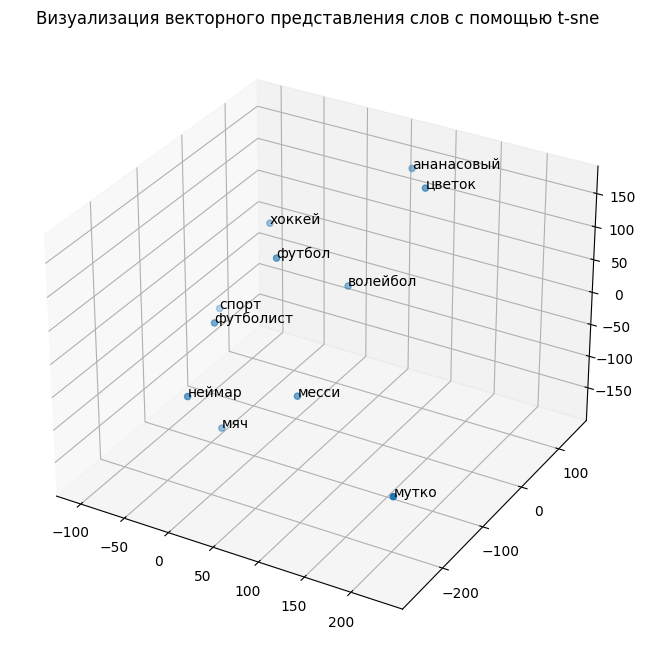

In [26]:
tsne = TSNE(n_components=3, random_state=42,perplexity=5)
word_vectors_3d = tsne.fit_transform(word_vectors[words_to_visualize])
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(word_vectors_3d[:, 0], word_vectors_3d[:, 1], word_vectors_3d[:, 2], marker='o')

for i, word in enumerate(words_to_visualize):
    ax.text(word_vectors_3d[i, 0], word_vectors_3d[i, 1], word_vectors_3d[i, 2], word)

plt.title('Визуализация векторного представления слов с помощью t-sne')
plt.show()


In [ ]:
w2v_model.save("/home/kenny/sber_ds_case/model/w2v/word2vec_skipgram.bin")

# На основе эмбедингов, полученных с помощью Word2Vec модели, обучим базовые модели и посмотрим на метрики качества

In [11]:
w2v_model = Word2Vec.load("/home/kenny/sber_ds_case/model/w2v/word2vec_skipgram.bin")

In [12]:
def vectorize(sentence, w2v_model):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [13]:
X_train = np.array([vectorize(sentence, w2v_model) for sentence in X_train])
y_train = np.array(y_train)

In [15]:
X_test = np.array([vectorize(sentence, w2v_model) for sentence in X_test])
y_test = np.array(y_test)

In [16]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("LogisticRegression: ")
print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))
print()

LogisticRegression: 
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     27246
           1       0.93      0.94      0.93     16079
           2       0.83      0.80      0.81      9009
           3       0.98      0.98      0.98     12914
           4       0.93      0.93      0.93     10637
           5       0.90      0.87      0.88     10547

    accuracy                           0.92     86432
   macro avg       0.91      0.91      0.91     86432
weighted avg       0.92      0.92      0.92     86432


[[25512   490   406    87   281   470]
 [  506 15045   307    34    50   137]
 [  705   373  7196    91   298   346]
 [  115    36    78 12634    27    24]
 [  316    46   298    28  9872    77]
 [  548   220   423    23   127  9206]]



In [17]:
# посчитаем ROC-AUC One-vs-Rest (OvR)
y_prob = clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"ROC-AUC ovr: {roc_auc}")

ROC-AUC ovr: 0.991598460702883


In [18]:
# посчитаем ROC-AUC One-vs-One (OvO)
y_prob = clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovo')
print(f"ROC-AUC ovo: {roc_auc}")

ROC-AUC ovo: 0.9911905134788558


In [12]:
model_name = "Random Forest"
rf_model = RandomForestClassifier(n_estimators=100,random_state=777)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Random Forest: ")
print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))
print()

Random Forest: 
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     27168
           1       0.93      0.94      0.93     15927
           2       0.85      0.77      0.81      8951
           3       0.98      0.97      0.98     12878
           4       0.92      0.92      0.92     10817
           5       0.91      0.89      0.90     10691

    accuracy                           0.92     86432
   macro avg       0.92      0.91      0.91     86432
weighted avg       0.92      0.92      0.92     86432


[[25737   395   288    54   247   447]
 [  490 14975   272    34    46   110]
 [  890   411  6879   106   350   315]
 [  185    50    61 12539    34     9]
 [  416    68   275    24  9958    76]
 [  527   212   326    11   146  9469]]



In [13]:
# посчитаем ROC-AUC One-vs-Rest (OvR)
y_prob = rf_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"ROC-AUC ovr: {roc_auc}")

ROC-AUC ovr: 0.9916627273325066


In [14]:
# посчитаем ROC-AUC One-vs-One (OvO)
y_prob = rf_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovo')
print(f"ROC-AUC ovo: {roc_auc}")

ROC-AUC ovo: 0.9909864730850981


In [12]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print("Support Vector Machine: ")
print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))
print()

Support Vector Machine: 
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     27168
           1       0.94      0.94      0.94     15927
           2       0.86      0.82      0.84      8951
           3       0.98      0.99      0.98     12878
           4       0.94      0.94      0.94     10817
           5       0.91      0.90      0.90     10691

    accuracy                           0.93     86432
   macro avg       0.93      0.92      0.92     86432
weighted avg       0.93      0.93      0.93     86432


[[25592   388   381    89   255   463]
 [  419 15046   250    47    46   119]
 [  609   311  7353   106   259   313]
 [   84    30    48 12687    24     5]
 [  271    29   238    28 10163    88]
 [  454   166   290    12   120  9649]]



Наивный Байес

In [104]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
print("Naive Bayes: ")
print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))
print()

Naive Bayes: 
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     27168
           1       0.89      0.90      0.90     15927
           2       0.65      0.73      0.69      8951
           3       0.99      0.92      0.95     12878
           4       0.85      0.87      0.86     10817
           5       0.84      0.82      0.83     10691

    accuracy                           0.87     86432
   macro avg       0.86      0.86      0.86     86432
weighted avg       0.87      0.87      0.87     86432


[[24259   561  1057    29   522   740]
 [  469 14392   689    19    48   310]
 [  690   589  6538    77   627   430]
 [  454   117   295 11852   119    41]
 [  477    89   727    28  9389   107]
 [  484   352   701    10   340  8804]]



In [108]:
# посчитаем ROC-AUC One-vs-Rest (OvR)
y_prob = nb_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"ROC-AUC ovr: {roc_auc}")

ROC-AUC ovr: 0.9796932429654661


In [109]:
# посчитаем ROC-AUC One-vs-One (OvO)
y_prob = nb_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovo')
print(f"ROC-AUC ovo: {roc_auc}")

ROC-AUC ovo: 0.9789096460554979


# Обучим KNN + word2vec

In [30]:
def knn_objective(trial: Trial) -> float:
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    log_losses = []
    
    for train_index, val_index in kf.split(X_train, y_train):
        X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
        y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)    
        knn.fit(X_train_kf, y_train_kf)
        
        y_pred = knn.predict_proba(X_val_kf)
        loss = log_loss(y_val_kf, y_pred)
        log_losses.append(loss)
    
    mean_log_loss = sum(log_losses) / len(log_losses)
    
    return mean_log_loss

In [31]:
knn_study = optuna.create_study(direction='minimize')
knn_study.optimize(knn_objective, n_trials=10)

[I 2023-09-05 19:52:13,399] A new study created in memory with name: no-name-d47f6471-4933-48f8-8d8e-6efb1626088a
[I 2023-09-05 19:54:44,537] Trial 0 finished with value: 0.3594473111267697 and parameters: {'n_neighbors': 24, 'weights': 'uniform'}. Best is trial 0 with value: 0.3594473111267697.
[I 2023-09-05 19:57:15,032] Trial 1 finished with value: 0.35461763496744214 and parameters: {'n_neighbors': 25, 'weights': 'uniform'}. Best is trial 1 with value: 0.35461763496744214.
[I 2023-09-05 19:59:44,225] Trial 2 finished with value: 1.1855981664376307 and parameters: {'n_neighbors': 3, 'weights': 'uniform'}. Best is trial 1 with value: 0.35461763496744214.
[I 2023-09-05 20:02:13,679] Trial 3 finished with value: 0.40740626594244367 and parameters: {'n_neighbors': 18, 'weights': 'distance'}. Best is trial 1 with value: 0.35461763496744214.
[I 2023-09-05 20:04:43,626] Trial 4 finished with value: 0.4968850741150243 and parameters: {'n_neighbors': 12, 'weights': 'distance'}. Best is trial

In [54]:
knn_study.best_params

{'n_neighbors': 30, 'weights': 'uniform'}

In [33]:
knn_params = knn_study.best_params
knn_model = KNeighborsClassifier(**knn_params)  
knn_model.fit(X_train, y_train)  

KNeighborsClassifier(n_neighbors=30)

In [79]:
y_pred = knn_model.predict(X_test)

print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     27168
           1       0.94      0.95      0.94     15927
           2       0.87      0.80      0.83      8951
           3       0.98      0.98      0.98     12878
           4       0.93      0.93      0.93     10817
           5       0.91      0.91      0.91     10691

    accuracy                           0.93     86432
   macro avg       0.93      0.92      0.92     86432
weighted avg       0.93      0.93      0.93     86432


[[25745   367   274    58   247   477]
 [  403 15083   237    40    50   114]
 [  719   342  7184    95   308   303]
 [  137    31    61 12605    38     6]
 [  293    33   245    20 10110   116]
 [  439   152   298     6   104  9692]]


In [80]:
# посчитаем ROC-AUC One-vs-Rest (OvR)
y_prob = knn_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"ROC-AUC ovr: {roc_auc}")

ROC-AUC ovr: 0.9923566199564385


In [82]:
# посчитаем ROC-AUC One-vs-One (OvO)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovo')
print(f"ROC-AUC ovo: {roc_auc}")

ROC-AUC ovo: 0.9919826263046715


# Обучим NearestNeighbors

In [84]:
nn_model = NearestNeighbors(n_neighbors=1)
nn_model.fit(X_train)

distances, indices = nn_model.kneighbors(X_test)
y_pred = y_train[indices]

In [85]:
print(classification_report(y_test, y_pred))
print('\n')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     27168
           1       0.93      0.94      0.94     15927
           2       0.83      0.82      0.83      8951
           3       0.98      0.98      0.98     12878
           4       0.93      0.93      0.93     10817
           5       0.89      0.90      0.89     10691

    accuracy                           0.92     86432
   macro avg       0.92      0.92      0.92     86432
weighted avg       0.92      0.92      0.92     86432



[[25390   474   441    71   270   522]
 [  460 14944   313    29    38   143]
 [  553   333  7339    84   285   357]
 [  123    54    91 12567    34     9]
 [  279    49   310    13 10016   150]
 [  484   159   346    10   113  9579]]


# Обучим LightGBM + word2vec

In [48]:
def lightgbm_objective(trial: Trial) -> float:

    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_class': 6,
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'num_boost_round': trial.suggest_int('num_boost_round', 10, 1000),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 5, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 20, 100),
        'early_stopping_round': 100,
        'verbose': -1,
    }
    params['device'] = 'gpu'
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    log_losses = []
    
    for train_index, val_index in kf.split(X_train, y_train):
        X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
        y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
        

        train_data = lgb.Dataset(X_train_kf, label=y_train_kf)
        val_data = lgb.Dataset(X_val_kf, label=y_val_kf)

        model = lgb.train(params, train_data, valid_sets=[val_data])
        
        y_pred = model.predict(X_val_kf)
        loss = log_loss(y_val_kf, y_pred)
        
        log_losses.append(loss)
    
    mean_log_loss = sum(log_losses) / len(log_losses)
    return mean_log_loss


In [50]:
lightgbm_study = optuna.create_study(direction='minimize')
lightgbm_study.optimize(lightgbm_objective, n_trials=5)

[I 2023-09-05 20:38:41,206] A new study created in memory with name: no-name-d8b7c05b-dd9a-4f3d-a2a5-084213f33fe5
[I 2023-09-05 20:42:04,154] Trial 0 finished with value: 1.7104084923880856 and parameters: {'num_leaves': 36, 'lambda_l1': 0.00015576655801295756, 'lambda_l2': 0.0005362439345381161, 'learning_rate': 4.348748504150784e-08, 'feature_fraction': 0.7550151863189081, 'bagging_fraction': 0.40117548779056644, 'bagging_freq': 10, 'min_child_samples': 30, 'num_boost_round': 614, 'early_stopping_rounds': 32, 'max_depth': 6, 'n_estimators': 88}. Best is trial 0 with value: 1.7104084923880856.
[I 2023-09-05 20:45:56,581] Trial 1 finished with value: 1.6641602084961182 and parameters: {'num_leaves': 162, 'lambda_l1': 0.04939598939168582, 'lambda_l2': 5.616120207734103e-06, 'learning_rate': 2.529053874666693e-05, 'feature_fraction': 0.1581634014440057, 'bagging_fraction': 0.25543722908964206, 'bagging_freq': 3, 'min_child_samples': 19, 'num_boost_round': 682, 'early_stopping_rounds': 45

In [51]:
lightgbm_study.best_params

{'num_leaves': 95,
 'lambda_l1': 6.619106997447745,
 'lambda_l2': 2.036449521076919e-08,
 'learning_rate': 0.015878235055890026,
 'feature_fraction': 0.5043490771104928,
 'bagging_fraction': 0.8399165172622783,
 'bagging_freq': 9,
 'min_child_samples': 10,
 'num_boost_round': 574,
 'early_stopping_rounds': 31,
 'max_depth': 9,
 'n_estimators': 40}

In [86]:
lightgbm_params = lightgbm_study.best_params

lightgbm_params['device'] = 'gpu'
lightgbm_params['objective'] = 'multiclass'
lightgbm_params['metric'] = 'multi_logloss'
lightgbm_params['boosting_type'] = 'gbdt'
lightgbm_params['num_class'] = 6
lightgbm_params['early_stopping_round'] = 100
lightgbm_params['verbose'] = -1

train_data = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.train(lightgbm_params, train_data, num_boost_round=1000, valid_sets=[train_data])

In [92]:
y_prob = lgb_model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     27168
           1       0.94      0.95      0.94     15927
           2       0.85      0.82      0.84      8951
           3       0.98      0.98      0.98     12878
           4       0.93      0.93      0.93     10817
           5       0.91      0.90      0.90     10691

    accuracy                           0.93     86432
   macro avg       0.92      0.92      0.92     86432
weighted avg       0.93      0.93      0.93     86432


[[25607   386   376    76   247   476]
 [  418 15059   257    34    47   112]
 [  629   326  7322    91   260   323]
 [  113    43    62 12624    29     7]
 [  307    34   250    28 10106    92]
 [  443   167   304    11   121  9645]]


In [93]:
# посчитаем ROC-AUC One-vs-Rest (OvR)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"ROC-AUC ovr: {roc_auc}")

ROC-AUC ovr: 0.994431693521756


In [94]:
# посчитаем ROC-AUC One-vs-One (OvO)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovo')
print(f"ROC-AUC ovo: {roc_auc}")

ROC-AUC ovo: 0.9940913728620112


# Обучим Catboost + word2vec

In [68]:
def catboost_objective(
    trial: Trial,
) -> float:
    """
    Calculates a trials for model params optimization
    """
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.2),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
        "iterations": trial.suggest_int("iterations", 800, 1500, 100),
        "random_strength": trial.suggest_float("random_strength", 1e-2, 1.0),
        "depth": trial.suggest_int("depth", 6, 12),
        "bootstrap_type": "Bayesian",
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 10),
        "task_type": "GPU",
    }
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    log_losses = []
    for train_index, val_index in kf.split(X_train, y_train):

        X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
        y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
        train_pool = Pool(
            data=X_train_kf,
            label=y_train_kf,
        )

        val_pool = Pool(
            data=X_val_kf,
            label=y_val_kf,
        )
        
        gbm = CatBoostClassifier(**params)
        gbm.fit(train_pool, eval_set=val_pool, verbose=200)
        
        y_pred = gbm.predict_proba(val_pool)
        loss = log_loss(y_val_kf, y_pred)
        
        log_losses.append(loss)
    
    mean_log_loss = sum(log_losses) / len(log_losses)
    
    return mean_log_loss

In [69]:
catboost_study = optuna.create_study(direction='minimize')
catboost_study.optimize(catboost_objective, n_trials=5)

[I 2023-09-05 21:17:49,160] A new study created in memory with name: no-name-8e091285-ba91-4424-9290-cbaf6be527d2


0:	learn: 1.2725303	test: 1.2745842	best: 1.2745842 (0)	total: 192ms	remaining: 3m 12s
200:	learn: 0.1637419	test: 0.2195669	best: 0.2195669 (200)	total: 23.9s	remaining: 1m 35s
400:	learn: 0.1175098	test: 0.2048764	best: 0.2048764 (400)	total: 46.9s	remaining: 1m 10s
600:	learn: 0.0882208	test: 0.1985311	best: 0.1985311 (600)	total: 1m 9s	remaining: 46.4s
800:	learn: 0.0679771	test: 0.1958772	best: 0.1958772 (800)	total: 1m 33s	remaining: 23.1s
999:	learn: 0.0546923	test: 0.1947820	best: 0.1947762 (996)	total: 1m 55s	remaining: 0us
bestTest = 0.1947761716
bestIteration = 996
Shrink model to first 997 iterations.
0:	learn: 1.2754026	test: 1.2778451	best: 1.2778451 (0)	total: 148ms	remaining: 2m 27s
200:	learn: 0.1631931	test: 0.2185300	best: 0.2185300 (200)	total: 24s	remaining: 1m 35s
400:	learn: 0.1183133	test: 0.2031737	best: 0.2031737 (400)	total: 47s	remaining: 1m 10s
600:	learn: 0.0903430	test: 0.1962204	best: 0.1962204 (600)	total: 1m 9s	remaining: 46.4s
800:	learn: 0.0706557	te

[I 2023-09-05 21:27:38,449] Trial 0 finished with value: 0.18871325873543338 and parameters: {'learning_rate': 0.19648393394336078, 'l2_leaf_reg': 7, 'iterations': 1000, 'random_strength': 0.3539730591902545, 'depth': 11, 'bagging_temperature': 6.448279512789355}. Best is trial 0 with value: 0.18871325873543338.


0:	learn: 1.3214473	test: 1.3240406	best: 1.3240406 (0)	total: 26.1ms	remaining: 39.2s
200:	learn: 0.1656176	test: 0.2107848	best: 0.2107848 (200)	total: 4.69s	remaining: 30.3s
400:	learn: 0.1244183	test: 0.1980466	best: 0.1980466 (400)	total: 9.1s	remaining: 24.9s
600:	learn: 0.0982265	test: 0.1927350	best: 0.1927350 (600)	total: 13.5s	remaining: 20.2s
800:	learn: 0.0784516	test: 0.1901534	best: 0.1901534 (800)	total: 17.9s	remaining: 15.7s
1000:	learn: 0.0628333	test: 0.1887387	best: 0.1887387 (1000)	total: 22.4s	remaining: 11.2s
1200:	learn: 0.0508867	test: 0.1889119	best: 0.1886755 (1073)	total: 26.9s	remaining: 6.7s
1400:	learn: 0.0414685	test: 0.1897051	best: 0.1886755 (1073)	total: 31.4s	remaining: 2.22s
1499:	learn: 0.0376425	test: 0.1902905	best: 0.1886755 (1073)	total: 33.6s	remaining: 0us
bestTest = 0.1886754595
bestIteration = 1073
Shrink model to first 1074 iterations.
0:	learn: 1.3347716	test: 1.3352914	best: 1.3352914 (0)	total: 25.3ms	remaining: 38s
200:	learn: 0.167123

[I 2023-09-05 21:30:34,687] Trial 1 finished with value: 0.18475214122162648 and parameters: {'learning_rate': 0.18433813991604778, 'l2_leaf_reg': 1, 'iterations': 1500, 'random_strength': 0.06967243130501688, 'depth': 7, 'bagging_temperature': 0.43831281258670307}. Best is trial 1 with value: 0.18475214122162648.


0:	learn: 1.2879018	test: 1.2904974	best: 1.2904974 (0)	total: 35.9ms	remaining: 50.2s
200:	learn: 0.1823003	test: 0.2207193	best: 0.2207193 (200)	total: 6.16s	remaining: 36.7s
400:	learn: 0.1487011	test: 0.2072502	best: 0.2072502 (400)	total: 11.8s	remaining: 29.5s
600:	learn: 0.1252973	test: 0.2005300	best: 0.2005300 (600)	total: 17.6s	remaining: 23.4s
800:	learn: 0.1075909	test: 0.1966906	best: 0.1966906 (800)	total: 23.4s	remaining: 17.5s
1000:	learn: 0.0926583	test: 0.1946223	best: 0.1946110 (999)	total: 29.1s	remaining: 11.6s
1200:	learn: 0.0797223	test: 0.1937553	best: 0.1937518 (1194)	total: 35s	remaining: 5.8s
1399:	learn: 0.0692878	test: 0.1934948	best: 0.1933733 (1314)	total: 40.8s	remaining: 0us
bestTest = 0.1933733146
bestIteration = 1314
Shrink model to first 1315 iterations.
0:	learn: 1.2981183	test: 1.2977681	best: 1.2977681 (0)	total: 37.1ms	remaining: 51.9s
200:	learn: 0.1814317	test: 0.2194238	best: 0.2194238 (200)	total: 6.18s	remaining: 36.9s
400:	learn: 0.1479149	

[I 2023-09-05 21:34:07,747] Trial 2 finished with value: 0.1873535755742281 and parameters: {'learning_rate': 0.19436718128847144, 'l2_leaf_reg': 3, 'iterations': 1400, 'random_strength': 0.4904929255326642, 'depth': 8, 'bagging_temperature': 2.2437329152328456}. Best is trial 1 with value: 0.18475214122162648.


0:	learn: 1.4181669	test: 1.4192548	best: 1.4192548 (0)	total: 93.9ms	remaining: 1m 33s
200:	learn: 0.1960335	test: 0.2290609	best: 0.2290609 (200)	total: 14.5s	remaining: 57.6s
400:	learn: 0.1597915	test: 0.2113265	best: 0.2113265 (400)	total: 27.9s	remaining: 41.6s
600:	learn: 0.1359679	test: 0.2025677	best: 0.2025677 (600)	total: 41.4s	remaining: 27.5s
800:	learn: 0.1165020	test: 0.1971213	best: 0.1971213 (800)	total: 55.1s	remaining: 13.7s
999:	learn: 0.1023120	test: 0.1939405	best: 0.1939405 (999)	total: 1m 8s	remaining: 0us
bestTest = 0.1939404739
bestIteration = 999
0:	learn: 1.4223768	test: 1.4238414	best: 1.4238414 (0)	total: 87.9ms	remaining: 1m 27s
200:	learn: 0.1989350	test: 0.2308861	best: 0.2308861 (200)	total: 14.3s	remaining: 56.7s
400:	learn: 0.1613328	test: 0.2111767	best: 0.2111767 (400)	total: 27.7s	remaining: 41.4s
600:	learn: 0.1372306	test: 0.2020291	best: 0.2020291 (600)	total: 41.2s	remaining: 27.3s
800:	learn: 0.1198695	test: 0.1967678	best: 0.1967678 (800)	to

[I 2023-09-05 21:39:57,339] Trial 3 finished with value: 0.19005801569115485 and parameters: {'learning_rate': 0.13585177566653217, 'l2_leaf_reg': 7, 'iterations': 1000, 'random_strength': 0.07119304571380701, 'depth': 10, 'bagging_temperature': 6.104538223529914}. Best is trial 1 with value: 0.18475214122162648.


0:	learn: 1.2986113	test: 1.3020851	best: 1.3020851 (0)	total: 289ms	remaining: 6m 14s
200:	learn: 0.1539162	test: 0.2171121	best: 0.2171121 (200)	total: 42.4s	remaining: 3m 51s
400:	learn: 0.1077275	test: 0.2023740	best: 0.2023740 (400)	total: 1m 22s	remaining: 3m 4s
600:	learn: 0.0798359	test: 0.1963209	best: 0.1963209 (600)	total: 2m 2s	remaining: 2m 22s
800:	learn: 0.0609724	test: 0.1935022	best: 0.1935019 (797)	total: 2m 42s	remaining: 1m 41s
1000:	learn: 0.0475271	test: 0.1922844	best: 0.1922568 (996)	total: 3m 22s	remaining: 1m
1200:	learn: 0.0375237	test: 0.1918988	best: 0.1918706 (1195)	total: 4m 2s	remaining: 20s
1299:	learn: 0.0338948	test: 0.1921908	best: 0.1918706 (1195)	total: 4m 22s	remaining: 0us
bestTest = 0.1918706348
bestIteration = 1195
Shrink model to first 1196 iterations.
0:	learn: 1.2854015	test: 1.2873462	best: 1.2873462 (0)	total: 265ms	remaining: 5m 44s
200:	learn: 0.1527026	test: 0.2177925	best: 0.2177925 (200)	total: 42.5s	remaining: 3m 52s
400:	learn: 0.10

[I 2023-09-05 22:02:00,827] Trial 4 finished with value: 0.18705480937082086 and parameters: {'learning_rate': 0.19276577873992037, 'l2_leaf_reg': 10, 'iterations': 1300, 'random_strength': 0.5660671604720214, 'depth': 12, 'bagging_temperature': 4.487415219022568}. Best is trial 1 with value: 0.18475214122162648.


In [70]:
catboost_study.best_params

{'learning_rate': 0.18433813991604778,
 'l2_leaf_reg': 1,
 'iterations': 1500,
 'random_strength': 0.06967243130501688,
 'depth': 7,
 'bagging_temperature': 0.43831281258670307}

In [71]:
train_pool = Pool(
    data=X_train,
    label=y_train,
)
catboost_params=catboost_study.best_params
catboost_params["bootstrap_type"] =  "Bayesian"
catboost_params["task_type"]="GPU"
catboost_model = CatBoostClassifier(**catboost_params)
catboost_model.fit(train_pool, eval_set=train_pool, verbose=200, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.3336603	test: 1.3336605	best: 1.3336605 (0)	total: 33.4ms	remaining: 50.1s
200:	learn: 0.1706357	test: 0.1706357	best: 0.1706357 (200)	total: 5.41s	remaining: 34.9s
400:	learn: 0.1328248	test: 0.1328247	best: 0.1328247 (400)	total: 10.5s	remaining: 28.7s
600:	learn: 0.1080874	test: 0.1080874	best: 0.1080874 (600)	total: 15.5s	remaining: 23.2s
800:	learn: 0.0900204	test: 0.0900205	best: 0.0900205 (800)	total: 20.5s	remaining: 17.9s
1000:	learn: 0.0747991	test: 0.0747991	best: 0.0747991 (1000)	total: 25.5s	remaining: 12.7s
1200:	learn: 0.0622179	test: 0.0622179	best: 0.0622179 (1200)	total: 30.6s	remaining: 7.62s
1400:	learn: 0.0524675	test: 0.0524675	best: 0.0524675 (1400)	total: 35.7s	remaining: 2.52s
1499:	learn: 0.0479610	test: 0.0479610	best: 0.0479610 (1499)	total: 38.3s	remaining: 0us
bestTest = 0.04796096204
bestIteration = 1499


In [73]:
test_pool = Pool(
    data=X_test,
    label=y_test,
)
y_pred = catboost_model.predict(test_pool)
print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     27168
           1       0.95      0.95      0.95     15927
           2       0.86      0.84      0.85      8951
           3       0.98      0.98      0.98     12878
           4       0.94      0.94      0.94     10817
           5       0.91      0.91      0.91     10691

    accuracy                           0.93     86432
   macro avg       0.93      0.93      0.93     86432
weighted avg       0.93      0.93      0.93     86432


[[25654   375   367    77   231   464]
 [  390 15094   246    33    42   122]
 [  540   276  7504    88   235   308]
 [   99    35    55 12659    26     4]
 [  280    29   210    24 10175    99]
 [  449   143   299     9   102  9689]]


In [74]:
# посчитаем ROC-AUC One-vs-Rest (OvR)
y_prob = catboost_model.predict_proba(test_pool)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"ROC-AUC ovr: {roc_auc}")

ROC-AUC ovr: 0.9951714098204568


In [76]:
# посчитаем ROC-AUC One-vs-One (OvO)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovo')
print(f"ROC-AUC ovo: {roc_auc}")

ROC-AUC ovo: 0.9949198425563818


# Попробуем теперь обучить CatBoost в холостую сразу на текстовых данных, не используя Word2Vec эмбединги

In [33]:
df_train = pd.read_csv(processed_data_path)
drop_cols = ["text", "title"]
df_train.drop(drop_cols, axis=1, inplace=True)
df_train, df_val = train_test_split(
    df_train, test_size=0.2, random_state=43, stratify=df_train["topic"]
)
cat_features = []
text_features = ["full_text"]
train_pool = Pool(
    data=df_train.drop(["topic"],axis=1),
    cat_features=cat_features,
    label=df_train["topic"],
    text_features=text_features,
)
catboost_params={
    'learning_rate': 0.18433813991604778,
    'l2_leaf_reg': 1,
    'iterations': 1500,
    'random_strength': 0.06967243130501688,
    'depth': 7,
    'bagging_temperature': 0.43831281258670307,
}
catboost_params["bootstrap_type"] =  "Bayesian"
catboost_params["task_type"]="GPU"
catboost_model = CatBoostClassifier(**catboost_params)
catboost_model.fit(train_pool, eval_set=train_pool, verbose=200, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.1111766	test: 1.1049796	best: 1.1049796 (0)	total: 55.8ms	remaining: 1m 23s
200:	learn: 0.1799385	test: 0.1680032	best: 0.1680032 (200)	total: 8.22s	remaining: 53.1s
400:	learn: 0.1547768	test: 0.1449538	best: 0.1449538 (400)	total: 15.6s	remaining: 42.7s
600:	learn: 0.1394613	test: 0.1307895	best: 0.1307895 (600)	total: 22.4s	remaining: 33.6s
800:	learn: 0.1284181	test: 0.1205284	best: 0.1205284 (800)	total: 29.1s	remaining: 25.4s
1000:	learn: 0.1192032	test: 0.1119486	best: 0.1119486 (1000)	total: 35.7s	remaining: 17.8s
1200:	learn: 0.1118695	test: 0.1051273	best: 0.1051273 (1200)	total: 42.1s	remaining: 10.5s
1400:	learn: 0.1052737	test: 0.0989868	best: 0.0989868 (1400)	total: 48.5s	remaining: 3.43s
1499:	learn: 0.1021580	test: 0.0961109	best: 0.0961109 (1499)	total: 51.7s	remaining: 0us
bestTest = 0.09611092852
bestIteration = 1499


In [34]:
test_pool = Pool(
    data=df_val.drop(["topic"],axis=1),
    cat_features=cat_features,
    label=df_val["topic"],
    text_features=text_features,
)

In [35]:
y_pred = catboost_model.predict(test_pool)
print(classification_report(df_val["topic"], y_pred))
print()
print(confusion_matrix(df_val["topic"], y_pred))

                 precision    recall  f1-score   support

 Интернет и СМИ       0.86      0.86      0.86      8933
       Культура       0.94      0.95      0.94     10759
            Мир       0.95      0.94      0.94     27324
Наука и техника       0.91      0.92      0.92     10627
          Спорт       0.98      0.99      0.99     12883
      Экономика       0.95      0.95      0.95     15906

       accuracy                           0.94     86432
      macro avg       0.93      0.93      0.93     86432
   weighted avg       0.94      0.94      0.94     86432


[[ 7654   244   458   272    58   247]
 [  240 10194   209    71    14    31]
 [  362   293 25772   404    91   402]
 [  292    89   369  9757     5   115]
 [   54    22    65    15 12707    20]
 [  286    48   352   147    39 15034]]


In [38]:
# посчитаем ROC-AUC One-vs-Rest (OvR)
y_prob = catboost_model.predict_proba(test_pool)
roc_auc = roc_auc_score(df_val["topic"], y_prob, multi_class='ovr')
print(f"ROC-AUC ovr: {roc_auc}")

ROC-AUC ovr: 0.9955294013559568


In [39]:
# посчитаем ROC-AUC One-vs-One (OvO)
roc_auc = roc_auc_score(df_val["topic"], y_prob, multi_class='ovo')
print(f"ROC-AUC ovo: {roc_auc}")

ROC-AUC ovo: 0.9953066018735685


Обучим полностью на всех данных

In [4]:
df_train = pd.read_csv(processed_data_path)
drop_cols = ["text", "title"]
df_train.drop(drop_cols, axis=1, inplace=True)
cat_features = []
text_features = ["full_text"]
train_pool = Pool(
    data=df_train.drop(["topic"],axis=1),
    cat_features=cat_features,
    label=df_train["topic"],
    text_features=text_features,
)
catboost_params={
    'learning_rate': 0.18433813991604778,
    'l2_leaf_reg': 1,
    'iterations': 1500,
    'random_strength': 0.06967243130501688,
    'depth': 7,
    'bagging_temperature': 0.43831281258670307,
}
catboost_params["bootstrap_type"] =  "Bayesian"
catboost_params["task_type"]="GPU"
catboost_model = CatBoostClassifier(**catboost_params)
catboost_model.fit(train_pool, eval_set=train_pool, verbose=200, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.1109169	test: 1.1059153	best: 1.1059153 (0)	total: 67.1ms	remaining: 1m 40s
200:	learn: 0.1809856	test: 0.1709941	best: 0.1709941 (200)	total: 9.57s	remaining: 1m 1s
400:	learn: 0.1572554	test: 0.1488295	best: 0.1488295 (400)	total: 18.2s	remaining: 49.8s
600:	learn: 0.1426308	test: 0.1351370	best: 0.1351370 (600)	total: 26.3s	remaining: 39.3s
800:	learn: 0.1318726	test: 0.1250706	best: 0.1250706 (800)	total: 34.1s	remaining: 29.7s
1000:	learn: 0.1234608	test: 0.1171807	best: 0.1171807 (1000)	total: 41.7s	remaining: 20.8s
1200:	learn: 0.1163852	test: 0.1105199	best: 0.1105199 (1200)	total: 49.2s	remaining: 12.2s
1400:	learn: 0.1099579	test: 0.1044811	best: 0.1044811 (1400)	total: 56.7s	remaining: 4.01s
1499:	learn: 0.1072113	test: 0.1018945	best: 0.1018945 (1499)	total: 1m	remaining: 0us
bestTest = 0.1018944551
bestIteration = 1499


In [40]:
path_to_model = "/home/kenny/sber_ds_case/model/catboost/catboost_classifier.cbm"
catboost_model.save_model(path_to_model)